# Final Project
## Group Orange

### Dependencies

In [41]:
import os, smtplib, numpy
from base64 import b64decode
from datetime import datetime
import matplotlib.pyplot as plt
from types import SimpleNamespace
from requests import get, Response
from email.mime.text import MIMEText
from pandas import read_csv, to_datetime, DataFrame

### Utils

In [42]:
def fetch_weather_data(latitude: float, longitude: float) -> Response:
    ''' Fetches the current weather data by performing a call to the open-meteo API. '''
    url = f'https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&hourly=temperature_2m'
    response = get(url)
    return response.json()

def csv_exists(filename: str = 'weather_data.csv') -> bool:
    ''' Checks if the weather data csv file exists. '''
    return os.path.isfile(filename)

def save_to_csv(data: object, filename: str = 'weather_data.csv'):
    ''' Saves the weather data in a csv file. '''
    timestamps = data['hourly']['time']
    temperatures = data['hourly']['temperature_2m']
    df = DataFrame({'timestamp': timestamps, 'temperature': temperatures})
    df['timestamp'] = to_datetime(df['timestamp'])

    df.to_csv(filename, mode='a' if csv_exists(filename) else 'w', header=not csv_exists(filename), index=False)

def send_email_alert(threshold: float, recipient: str, subject: str = 'Weather Alert') -> bool:
    ''' Sends an email containing weather alerts to a registered user. '''
    sender = 'alerts.deac110@gmail.com'
    password = b64decode('ZmtuZSB4cGp2IG5nZ2EgcXd3bw==').decode('utf-8')
    
    msg = MIMEText(f'The current temperature is above the preset threshold of {threshold} °C and predicted to continue until the end of the day.')
    msg['Subject'] = subject
    msg['From'] = sender    
    msg['To'] = recipient

    try:
        with smtplib.SMTP('smtp.gmail.com', 587) as smtp_server:
            smtp_server.ehlo()
            smtp_server.starttls()
            smtp_server.login(sender, password)
            smtp_server.sendmail(sender, recipient, msg.as_string())
            smtp_server.close()
            return True
    except Exception as e:
        print(f"Failed to send email: {e}")
        return False
    
def plot_insights(threshold: float, filename: str = 'weather_data.csv'):
    ''' Plots the historical and forecasted weather data. '''
    df = read_csv(filename)
    df['timestamp'] = to_datetime(df['timestamp'])

    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['temperature'], label='Historical Temperature')
    plt.axhline(y=threshold, color='r', linestyle='-', label=f'Threshold: {threshold}°C')

    today = datetime.now().date()

    plt.axvline(today, color='darkgreen', linestyle='--', label="Today's Date")
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Weather Forecast')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.figure(figsize=(12, 6))
    plt.hist(df['temperature'], bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(threshold, color='r', linestyle='-', label=f'Threshold: {threshold}°C')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.title('Temperature Distribution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

def is_bad_weather(threshold: float, filename: str = 'weather_data.csv') -> bool:
    ''' Checks if the weather data exceeds the preset threshold. '''
    df = read_csv(filename)
    timestamps = df['timestamp']
    df['timestamp'] = to_datetime(timestamps)
    last_timestamp = timestamps.max()
    today_temps = df[timestamps == last_timestamp]['temperature'].values
    return any(temp > threshold for temp in today_temps)

def get_threshold(delta: int = 10, filename: str = 'weather_data.csv') -> float:
    ''' Generates a random threshold value. '''
    mean_temp = numpy.mean(read_csv(filename)['temperature']) if csv_exists(filename) else numpy.random.randint(0, 30)
    return round(numpy.random.uniform(mean_temp - delta, mean_temp + delta), 2)

def main_pipeline(latitude: float, longitude: float, recipient: str):
    ''' The main data pipeline that performs all the above operations. '''
    threshold = get_threshold()
    save_to_csv(fetch_weather_data(latitude, longitude))
    print('Alert sent successfully' if is_bad_weather(threshold) and send_email_alert(threshold, recipient) else 'No bad weather predicted for today.')
    plot_insights(threshold)

### Main

Alert sent successfully


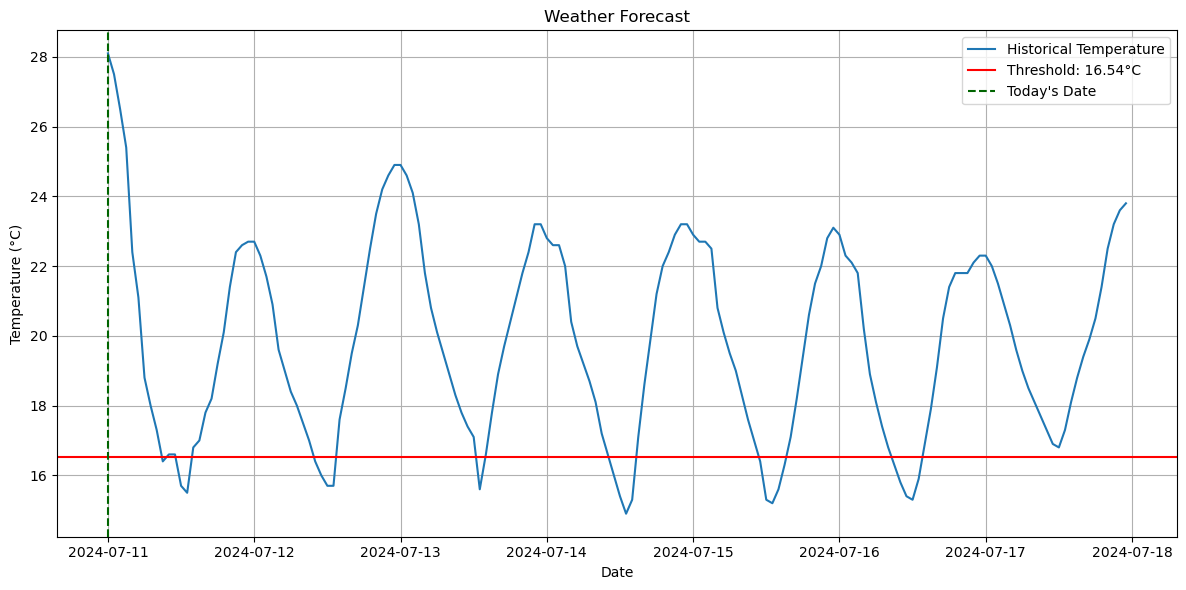

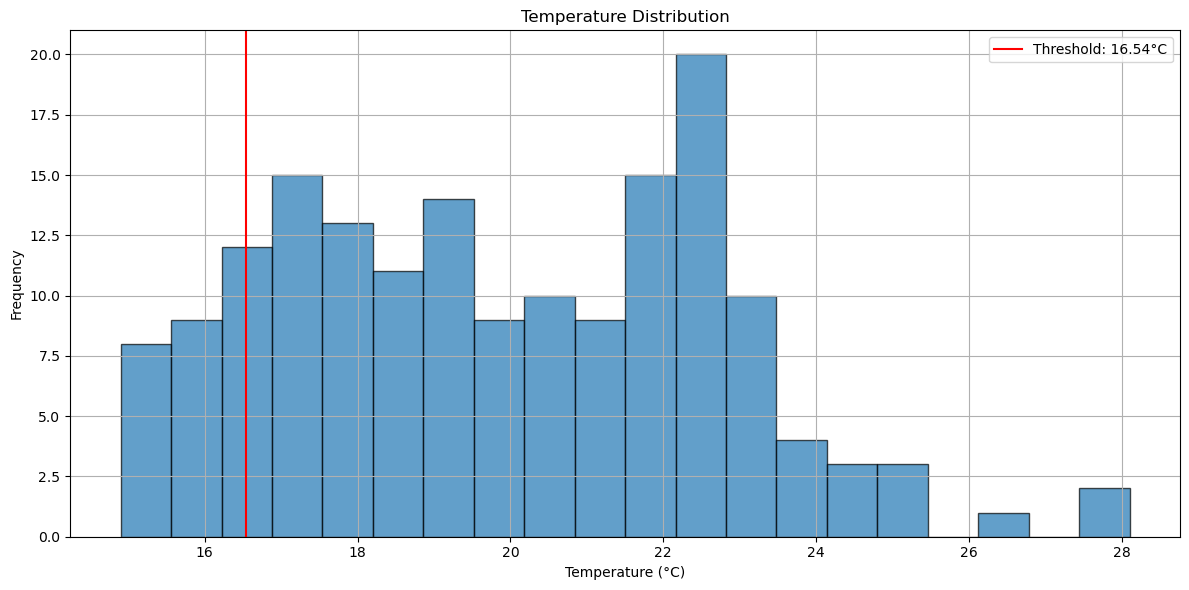

In [43]:
cctb_location = SimpleNamespace(
    latitude = 49.2767652224283, 
    longitude = -123.11565461478676
)

main_pipeline(cctb_location.latitude, cctb_location.longitude, recipient='youremail@domain.com')